First install the repo and requirements.

In [ ]:
%pip --quiet install git+https://github.com/mfinzi/equivariant-MLP.git

# Implementing New Representations

As our solver treats objects very generally, implementing new representations is surprisingly easy. To implement a new [Representation](https://emlp.readthedocs.io/en/latest/package/emlp.solver.representation.html#emlp.models.solver.representation.Rep) you need to implement `size()` which is the dimension of the representation, `rho(M)` which is a mapping from the group elements to the representation matrix, as well `__eq__` and `__hash__` to distinguish different representations. It's also a good idea to implement a `__str__` function to improve readability. All representations implemented this way should have the `.G` attribute specifying the symmetry group.

The implementation also requires you to specify whether the representation is regular (whether `rho(M)` outputs a permutaiton matrix) with the `is_regular` attribute, and also the `.T` property that returns the dual of the representation. We plan on removing these two requirements in a later release.

## Example 1: Irreducible Representations of SO(2) 

As a first example, we show one can implement the real irreducible representations of the group SO(2). All of irreducible representations $\psi_n$ of SO(2) are $2$-dimensional (except for $\psi_0$ which is the same as [Scalar](https://emlp.readthedocs.io/en/latest/package/emlp.solver.representation.html#emlp.models.solver.representation.Scalar) $= \mathbb{R} = \psi_0$). These representations can be written $\psi_n(R_\theta) = \begin{bmatrix}\cos(n\theta) &\sin(n\theta)\\-\sin(n\theta) &  \cos(n\theta) \end{bmatrix}$ or simply: $\psi_n(R) = R^n$.

In [1]:
import jax.numpy as jnp
from emlp.reps import Rep,vis,V,equivariance_error
from emlp.groups import SO,S

class SO2Irreps(Rep):
    """ (Real) Irreducible representations of SO2 """
    is_regular=False
    def __init__(self,order):
        assert order>0, "Use Scalar for 𝜓₀"
        self.G=SO(2)
        self.order = order
    def size(self):
        return 2
    def rho(self,M):
        return jnp.linalg.matrix_power(M,self.order)
    def __str__(self):
        number2sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
        return f"𝜓{self.order}".translate(number2sub)
    def __eq__(self,other):
        return type(self)==type(other) and self.G==other.G and self.order==other.order
    def __hash__(self):
        return hash((type(self),self.G,self.order))
    @property
    def T(self):
        return self

That's it! Now we can use the SO(2) irreps in the type system, and solve for equivariant bases that contain them.

In [2]:
psi1 = SO2Irreps(1)
psi2 = SO2Irreps(2)
psi3 = SO2Irreps(3)

In [3]:
psi1*psi2+psi3

𝜓₃+𝜓₂⊗𝜓₁

We can verify [schur's lemma](https://en.wikipedia.org/wiki/Schur%27s_lemma), that there are no nontrivial equivariant linear maps from one irrep to another:

In [4]:
print((psi1>>psi2).symmetric_basis(),(psi2>>psi3).symmetric_basis(),(psi1>>psi3).symmetric_basis())

[] [] []


And we can include non irreducibles in our representation too. For example computing equivariant maps from $T_4 \rightarrow \psi_2$.

𝜓₂⊗V⁴ equivariant maps with r=8 basis elements


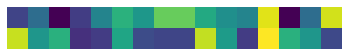

In [5]:
vis(V(SO(2))**4,psi2,False)
Wrep = V(SO(2))**4>>psi2
Q = Wrep.symmetric_basis()
print("{} equivariant maps with r={} basis elements".format(Wrep,Q.shape[-1]))

In [6]:
import numpy as np
W = Q@np.random.randn(Q.shape[-1])
print("With equivariance error {:.2e}".format(equivariance_error(W,V(SO(2))**4,psi2,SO(2))))

With equivariance error 2.58e-07


## Example 2: PseudoScalars, PseudoVectors, ...

With a slightly more sophisticated example, we'll now implement the representations known as [PseudoScalars](https://en.wikipedia.org/wiki/Pseudoscalar), [PseudoVectors](https://en.wikipedia.org/wiki/Pseudovector), and other PseudoTensor representations. These representations commonly occur in physics when working with cross products or the Hodge star, and also describe the Fermi statistics of spin 1/2 particles that are antisymmetric under exchange.

A pseudoscalar is like a scalar `Scalar` $=\mathbb{R}$, but incurs a $-1$ under orientation reversing transformations: $\rho(M) = \mathrm{sign}(\mathrm{det}(M))$. Similarly, pseudovectors are like ordinary vectors but can pick up this additional $-1$ factor. In fact, we can convert any representation into a pseudorepresentation by multiplying by a pseudoscalar.

<!-- For when the group $G$ is the symmetric group $S_n$, the sign of the determinant of the permutation matrices $\sigma\in G$ is nothing but the parity of the permutation $(-1)^{N(\sigma)}$ -->

In [7]:
from emlp.reps import Rep,V,T,vis,Scalar

In [8]:
class PseudoScalar(Rep):
    is_regular=False
    def __init__(self,G=None):
        self.G=G
    def __call__(self,G):
        return PseudoScalar(G)
    def size(self):
        return 1
    def __str__(self):
        return "P"
    def rho(self,M):
        sign = jnp.linalg.slogdet(M@jnp.eye(M.shape[0]))[0]
        return sign*jnp.eye(1)
    def __eq__(self,other):
        return type(self)==type(other) and self.G==other.G
    def __hash__(self):
        return hash((type(self),self.G))
    @property
    def T(self):
        return self

In [18]:
G = S(4)
P = PseudoScalar(G)
W = V(G)

We can then build up pseudotensors with multiplication. As expected pseudovectors incur a -1 for odd permutations.

In [19]:
pseudovector = P*W
g = G.sample()
print(f"Sample g = \n{g}")
print(f"Pseudovector 𝜌 = \n{pseudovector.rho_dense(g)}")

Sample g = 
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
Pseudovector 𝜌 = 
[[-1.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]]


Again, we can freely mix and match these new representations with existing ones.

In [11]:
P*(W**2 +P)+W.T

P²+V+P⊗V²

Equivariant maps from matrices to pseodovectors yield a different set of solutions from maps from matrices to vectors.

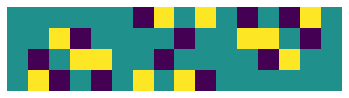

In [12]:
vis(W**2,pseudovector,cluster=False)

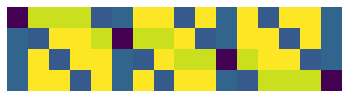

In [13]:
vis(W**2,W,cluster=False)

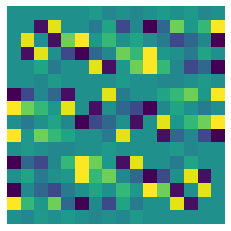

In [14]:
vis(P*W**2,W**2,cluster=False)

And of course we can verify the equivariance:

In [15]:
rin = P*W**2
rout = W**2
Q = (rin>>rout).symmetric_basis()
print(f"With equivariance error {equivariance_error(Q,rin,rout,G):.2e}")

With equivariance error 6.21e-08


We can even mix and match with the irreducible representations above.

In [16]:
P = PseudoScalar(SO(2))
W = V(SO(2))
rep = psi2>>P*W**2
print(rep)
print(rep.symmetric_basis().shape)

P⊗𝜓₂⊗V²
(8, 2)


## Additional Information 

Several other functions may be optionally implemented to improve performance such as the Lie Algebra representation `drho(A)` which by default is calculated automatically from `rho` as $d\rho(A) := d\rho(M)|_{M=I}(A) = \frac{d}{dt} \rho(e^{tA})|_{t=0}$, the dual representation `.T`. However, these functions are optional and the representation can function fine without them.